In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [2]:
!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 1.2 MB/s eta 0:00:00


In [3]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 865.0 kB/s eta 0:00:00


In [5]:
!pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 1.6 MB/s eta 0:00:00


In [8]:
!pip install tensorflow

     -------------------------------------- 266.3/266.3 MB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 2.1 MB/s eta 0:00:00
     -------------------------------------- 895.9/895.9 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 1.9 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 2.5 MB/s eta 0:00:00
     -------------------------------------- 439.2/439.2 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 2.1 MB/s eta 0:00:00
     -------------------------------------- 781.3/781.3 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 177.

In [9]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")

Matplotlib is building the font cache; this may take a moment.


All modules have been imported


In [11]:
!apt-get install tree
clear_output()

In [18]:
IMG_PATH = "C:/Users/Dell/Desktop/PROJECT DATA/Brain_Tumor_Detection/"

# split the data by train/val/test
ignored = {"pred"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 300:
                    shutil.copy(img, 'C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/test/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.8*IMG_NUM:
                    shutil.copy(img, 'C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/train/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/val/'+ CLASS.upper() + '/' + FILE_NAME)

In [19]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
TRAIN_DIR = 'C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/train/'
TEST_DIR = 'C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/test/'
VAL_DIR = 'C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/val/'
IMG_SIZE = (224,224)

In [21]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:18<00:00,  9.33s/it]
C:\Users\Dell\AppData\Local\Temp\ipykernel_7384\4020615754.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



1800 images loaded from C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/train/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  3.00s/it]


600 images loaded from C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/test/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]

600 images loaded from C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/val/ directory.


In [22]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [23]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

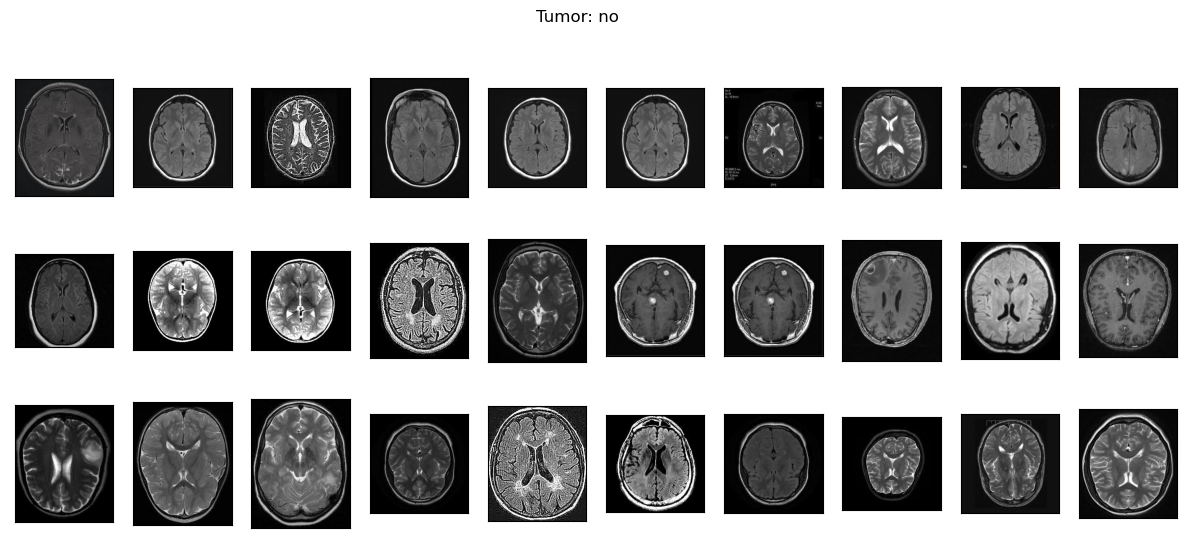

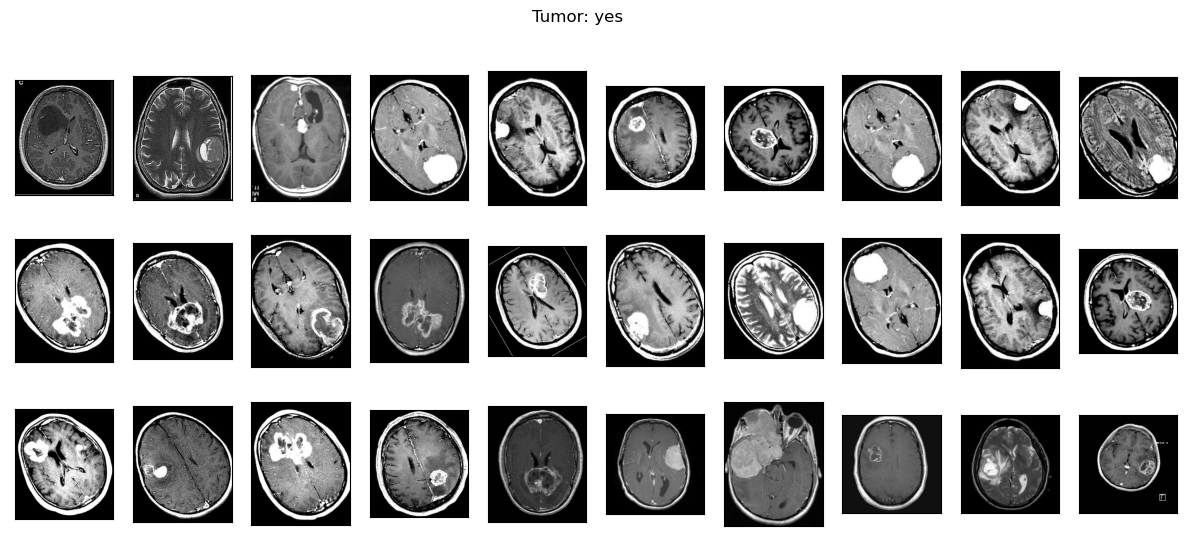

In [24]:
plot_samples(X_train, y_train, labels, 30)

In [25]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [29]:
import imutils
first=("C:/Users/Dell/Desktop/PROJECT DATA/vgg-19/val/no/no852.jpg")
img = cv2.imread(first)
#img = cv2.resize(
#            img,
#            dsize=IMG_SIZE,
#            interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

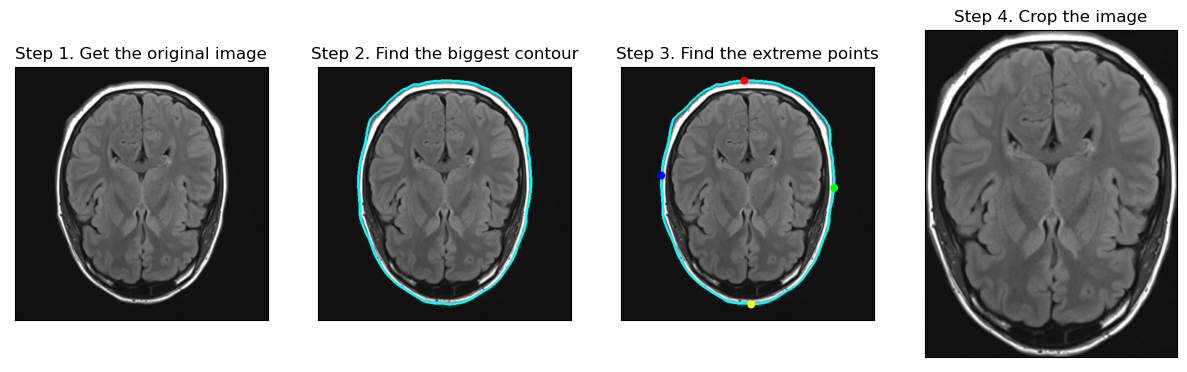

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [45]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

C:\Users\Dell\AppData\Local\Temp\ipykernel_7384\2254567846.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [46]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'no/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'yes/'+str(i)+'.jpg', img)
        i += 1

In [47]:
save_new_images(X_train_crop, y_train, folder_name='C:/Users/Dell/Desktop/PROJECT DATA/test/TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='C:/Users/Dell/Desktop/PROJECT DATA/test/VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='C:/Users/Dell/Desktop/PROJECT DATA/test/TEST_CROP/')

In [48]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [49]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

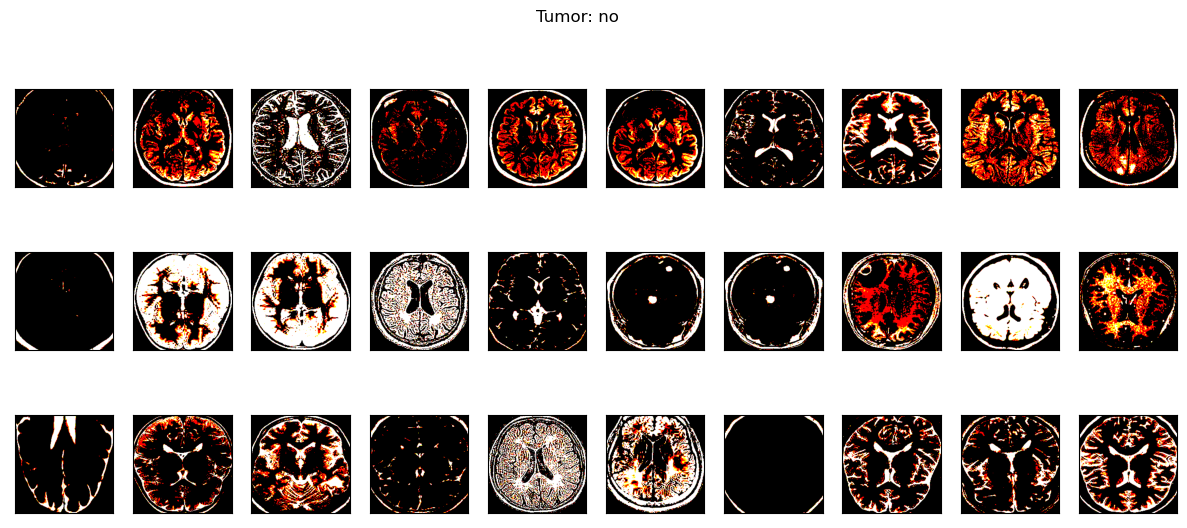

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

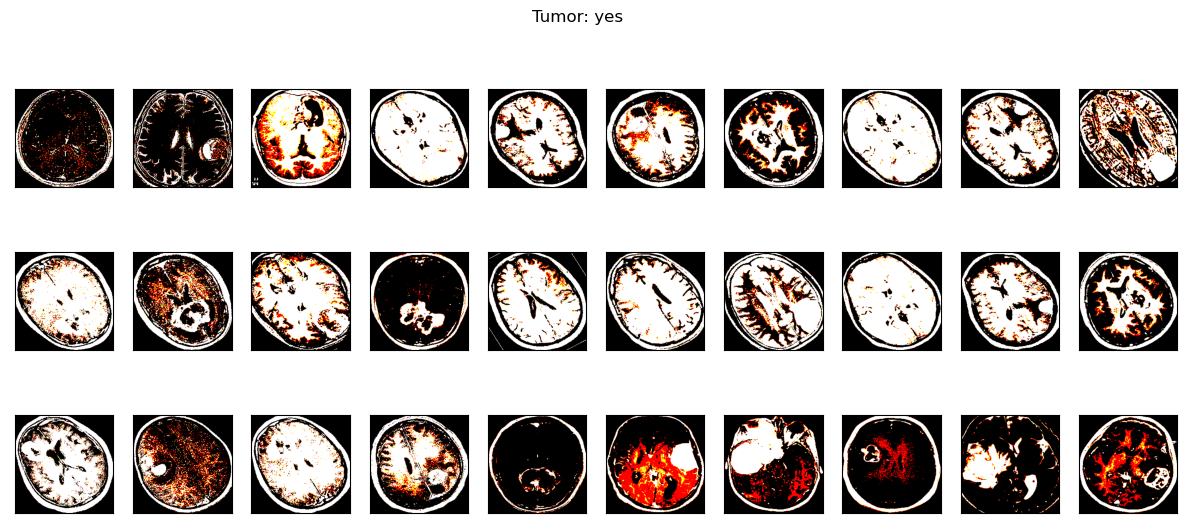

In [50]:
plot_samples(X_train_prep, y_train, labels, 30)

In [51]:
TRAIN_DIR = 'C:/Users/Dell/Desktop/PROJECT DATA/test/TRAIN_CROP/'
VAL_DIR = 'C:/Users/Dell/Desktop/PROJECT DATA/test/VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [52]:
base_Neural_Net= VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

80134624/80134624 [==============================] - 67s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                        

In [53]:
EPOCHS = 5
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator)
    ,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[es]
)

C:\Users\Dell\AppData\Local\Temp\ipykernel_7384\3060778119.py:7: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5
57/57 [==============================] - 1018s 18s/step - loss: 0.2895 - accuracy: 0.8822 - auc: 0.9518 - val_loss: 0.2200 - val_accuracy: 0.9517 - val_auc: 0.9871
Epoch 2/5
57/57 [==============================] - 737s 13s/step - loss: 0.0575 - accuracy: 0.9883 - auc: 0.9991 - val_loss: 0.0827 - val_accuracy: 0.9717 - val_auc: 0.9955
Epoch 3/5
57/57 [==============================] - 740s 13s/step - loss: 0.0370 - accuracy: 0.9900 - auc: 0.9996 - val_loss: 0.0624 - val_accuracy: 0.9783 - val_auc: 0.9971
Epoch 4/5
57/57 [==============================] - 751s 13s/step - loss: 0.0214 - accuracy: 0.9972 - auc: 0.9999 - val_loss: 0.0529 - val_accuracy: 0.9783 - val_auc: 0.9993
Epoch 5/5
57/57 [==============================] - 738s 13s/step - loss: 0.0144 - accuracy: 0.9967 - auc: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9867 - val_auc: 0.9992


57/57 [==============================] - 557s 10s/step
Train Accuracy = 1.00


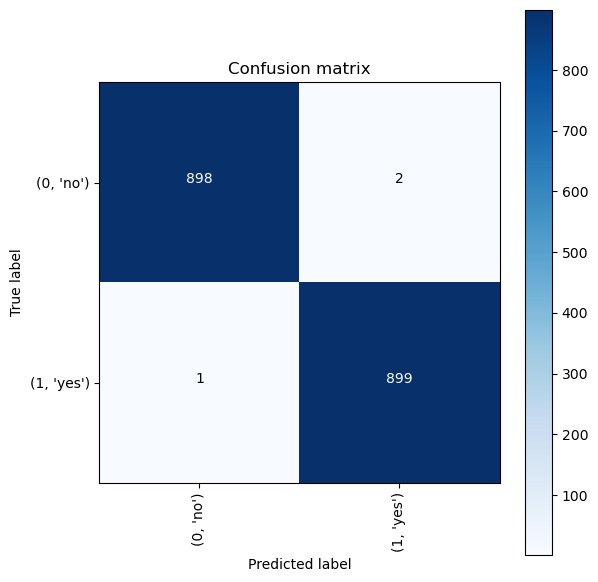

In [54]:
predictions = model.predict(X_train_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 181s 10s/step
Val Accuracy = 0.98


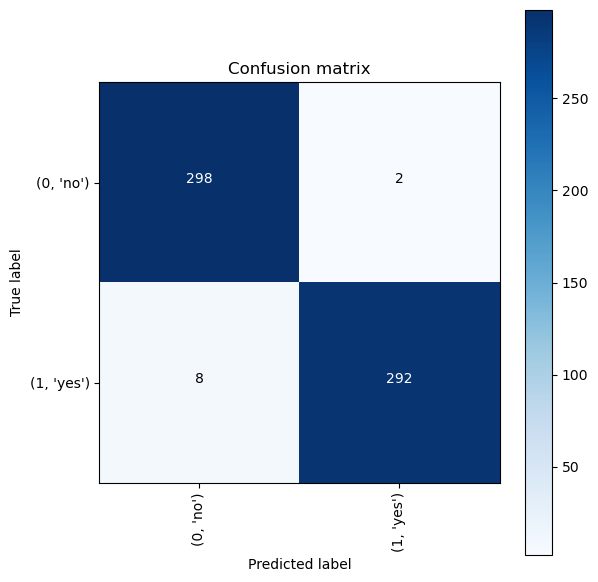

In [56]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

19/19 [==============================] - 178s 9s/step
Test Accuracy = 0.99


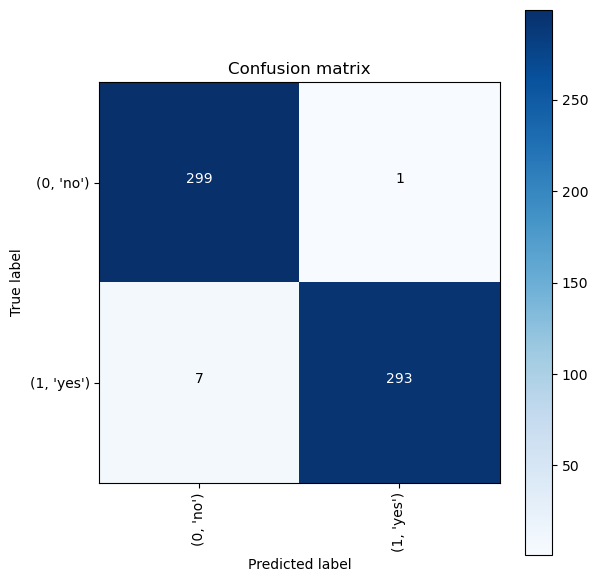

In [57]:
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [59]:
prob_pred = model.predict(X_test_prep)

19/19 [==============================] - 178s 9s/step


In [60]:
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, predictions))
print('Precision score is :', metrics.precision_score(y_test, predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, predictions, average='weighted'))
print('ROC AUC Score is :', metrics.roc_auc_score(y_test, prob_pred,multi_class='ovo', average='weighted'))
print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, predictions))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9866666666666667
Precision score is : 0.9868614112311591
Recall score is : 0.9866666666666667
F1 Score is : 0.9866653331999866
ROC AUC Score is : 0.9969222222222223
Cohen Kappa Score: 0.9733333333333334
		Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       300
           1       1.00      0.98      0.99       300

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

